# 脉冲神经网络的在线学习


在[关键概念](./concepts-zh.ipynb)一章中，我们介绍了`brainscale`在线学习的基础知识。在本节中，我们将讨论如何基于``brainscale``进行脉冲神经网络（Spiking Neural Networks，SNNs）的在线学习。

脉冲神经网络（Spiking Neural Networks, SNNs）是生物神经系统的一种更真实的建模方式，其核心在于使用离散的脉冲信号传递信息。与传统的神经网络不同，SNNs通过脉冲时间编码（Temporal Coding）来捕捉信息，强调了脉冲发放的时序和频率。在在线学习中，SNNs能够通过对脉冲事件的实时处理，适应动态环境，实现持续学习。这种学习方式不仅提高了计算效率，还使得网络在时间和空间上具备更强的适应能力，能有效处理时间序列数据。

In [1]:
import brainstate as bst
import braintools as bts
import brainunit as u

import brainscale

## 1. SNNs的基本概念

一般来说，一个脉冲神经网络分包含至少三个部分：一个部分是神经元的动力学，第二部分是突触的动力学，第三部分是神经元之间通过突触连接形成的动力学的交互。在这里，我们将基于简单的样例来介绍这三个部分的基本概念。

**LIF神经元模型**

最常见的神经元模型是 Leaky Integrate-and-fire (LIF) 神经元模型，其动力学方程如下：

$$
\begin{aligned}
\tau_m \frac{dV}{dt} =& -V + V_\mathrm{rest} + R I, \\
Z =& \Theta(V - V_{\mathrm{th}}), \\
V =& V_{\mathrm{reset}} \quad \text{if} \quad Z = 1
\end{aligned}
$$

其中，$V$ 是神经元的膜电位，$\tau_m$ 是膜电位的时间常数，$V_{\mathrm{rest}}$ 是静息电位，$R$ 是膜电阻，$I$ 是输入电流，$V_{\mathrm{th}}$ 是阈值电位，$\Theta$ 是阶跃函数，$Z$ 是输出脉冲，$V_{\mathrm{reset}}$ 是重置电位。

LIF 神经元模拟了神经元的兴奋和抑制过程。当输入电流 $I$ 足够大，使得膜电位 $V$ 超过阈值电位 $V_{\mathrm{th}}$ 时，神经元会发放脉冲。在发放脉冲后，膜电位会被重置为 $V_{\mathrm{reset}}$，并且在接下来的一段时间内，膜电位会逐渐恢复到静息电位 $V_{\mathrm{rest}}$。

![神经元脉冲发放过程](../_static/neuron-spike.gif)

我们将上述方程转化为离散形式，得到：

$$
\begin{aligned}
V(t+1) =& V(t) + \frac{\Delta t}{\tau_m} (-V(t) + V_{\mathrm{rest}} + R I), \\
Z(t) =& \Theta(V(t) - V_{\mathrm{th}}), \\
V(t+1) =& (1 - Z(t)) * V(t+1) + Z(t) V_{\mathrm{reset}}
\end{aligned}
$$



**突触模型**

最常见的突触模型是指数突触模型，其动力学方程如下：

$$
\tau_s \frac{ds}{dt} = -s + \sum_i  W_i \delta(t - t_i),
$$

其中，$s$ 是突触后电流，$\tau_s$ 是突触后电流的时间常数，$t_i$ 是突触前神经元发放脉冲的时间。

突触后电流 $s$ 是突触前神经元发放脉冲的叠加，而不是突触前神经元发放脉冲的数量。突触后电流 $s$ 会随着时间的推移而衰减，直到下一个突触前神经元发放脉冲。

值得注意的是，指数突触模型可以很好地使用 AlignPost 方法来建模，正如[我们论文](https://doi.org/10.1101/2024.09.24.614728)中所提到的那样。在 AlignPost 方法中，突触后电流 $s$ 的维度与神经元的维度相同，每个维度对应所有汇聚到该神经元的所有突触电流。

我们将上述方程转化为离散形式，得到：

$$
\begin{aligned}
s(t+1) =& \alpha s(t) + W_1 Z_1(t) + \cdots + W_n Z_n(t) \\
I =& s(t)
\end{aligned}
$$

其中，$\alpha = \exp(-\Delta t / \tau_s)$ 是突触后电流的衰减系数，$W_i$ 是第$i$个突触连接中的突触权重，$Z_i(t)$ 是突触前神经元群 $i$ 在时间 $t$ 的输出脉冲，$I$ 是上面LIF神经元接收到的总输入电流。


另外，使用指数族突触模型来建模突触动力学中，经常使用的另一个模型是双指数突触模型。双指数突触模型在指数突触模型的基础上，增加了一个时间常数，用于描述突触后电流的上升和下降过程。指数突触和双指数突触模型的区别如下图所示：


![Exponential-family synapse](../_static/expo-synapse.png)




**脉冲神经网络模型**

基于上述的LIF神经元模型和指数突触模型，我们可以构建一个简单的脉冲神经网络模型。在这个模型中，我们假设神经元之间是全连接的，即每个神经元都与其他神经元相连。我们按照向量的形式，将整个网络的动力学方程表示如下：

$$
\begin{aligned}
\mathbf{V}(t+1) =& \mathbf{V}(t) + \frac{\Delta t}{\tau_m} (-\mathbf{V}(t) + V_{\mathrm{rest}} + R \mathbf{I}), \\
\mathbf{Z}(t) =& \Theta(\mathbf{V}(t) - V_{\mathrm{th}}), \\
\mathbf{V}(t+1) =& (1 - \mathbf{Z}(t)) \odot \mathbf{V}(t+1) + \mathbf{Z}(t) \odot V_{\mathrm{reset}}, \\
\mathbf{s}(t+1) =& \alpha \mathbf{s}(t) + \mathbf{W}^\mathrm{in} \mathbf{Z}^\mathrm{in}(t) + \mathbf{W}^\mathrm{rec} \mathbf{Z}(t), \\
\mathbf{I} =& \mathbf{s}(t)
\end{aligned}
$$

其中，$\mathbf{V}$ 是神经元的膜电位向量，$\mathbf{I}$ 是输入电流向量，$\mathbf{Z}$ 是输出脉冲向量，$\mathbf{s}$ 是突触后电流向量，$\mathbf{W}^\mathrm{in}$ 是输入突触权重矩阵，$\mathbf{W}^\mathrm{rec}$ 是网络内循环连接突触权重矩阵，$\mathbf{Z}^\mathrm{in}$ 是输入脉冲向量。

**更多参考内容**

上面我们只是简单地介绍了脉冲神经网络的基本概念，实际上，脉冲神经网络的动力学非常丰富。它可以包含非常多样性的神经元动力学、突触动力学、以及复杂的神经网络之间的拓扑结构。更多的内容可以参见[我们的论文](https://doi.org/10.1101/2024.09.24.614728)。在实际应用中，我们需要根据具体的任务需求，选择合适的神经元模型和突触模型，设计合理的网络结构，以及调整网络参数，来实现我们的目标。


## 2. 使用LIF SNN进行Meromorphic-MNIST的在线学习

脉冲神经网络已经被广泛应用于类脑计算（brain-inspired computing）的各种任务，例如图像分类、目标检测、语音识别等。在这里，我们将使用上面介绍的脉冲神经网络模型，来解决一个Meromorphic-MNIST任务。

### 2.1 N-MNIST数据集

[Meromorphic-MNIST数据集](https://www.garrickorchard.com/datasets/n-mnist)基于经典的 MNIST 手写数字数据集，通过模拟生物神经元的脉冲发放特性，将静态图像转换为脉冲序列。Neuromorphic-MNIST 数据集的构建过程涉及将每个手写数字图像转换为脉冲信号。这一过程通常包括以下步骤：（1）图像预处理：原始的 MNIST 图像（28x28 像素，灰度图）被标准化，以确保输入数据的一致性。（2）时间编码：通过不同的时间编码策略（如频率编码或时间编码），将像素强度映射为脉冲序列。例如，可以通过固定时间窗口内的脉冲发放频率表示像素亮度。Neuromorphic-MNIST 数据集提供的脉冲序列反映了生物神经元对外部刺激的动态响应，适合用于时序数据处理的模型。

我们可以使用 [tonic](https://tonic.readthedocs.io)来加载 N-MNIST 数据集。以下是一个简单的例子：


In [2]:
import tonic
from tonic.datasets import NMNIST
from torch.utils.data import DataLoader


# 使用numpy_collate函数将数据集转换为numpy数组
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple, list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)


# 数据集
in_shape = NMNIST.sensor_size
out_shape = 10
data = NMNIST(save_to='../../examples/data/', train=True, first_saccade_only=True,
              transform=tonic.transforms.ToFrame(sensor_size=in_shape, n_time_bins=200))

# 使用PyTorch DataLoader加载数据集
data = DataLoader(
    data,
    shuffle=True,
    batch_size=256,
    collate_fn=numpy_collate,
    drop_last=True,
)

### 2.2 LIF神经网络模型

我们将使用上面介绍的LIF神经元模型和指数突触模型，构建一个简单的三层脉冲神经网络模型。这个模型包含一个输入层、一个隐藏层和一个输出层。输入层接收 N-MNIST 数据集的脉冲序列，隐藏层使用 LIF 神经元模型，输出层使用 LeakyRateReadout 来预测数字标签。


In [3]:
from typing import Callable
import matplotlib.pyplot as plt
import numpy as np


class LIF_Delta_Net(bst.nn.Module):
    """
    LIF neurons and dense connected delta synapses.
    """

    def __init__(
        self,
        n_in, n_rec, n_out,
        tau_mem=5. * u.ms,
        tau_o=5. * u.ms,
        V_th=1. * u.mV,
        spk_fun: Callable = bst.surrogate.ReluGrad(),
        spk_reset: str = 'soft',
        rec_scale: float = 1.,
        ff_scale: float = 1.,
    ):
        super().__init__()
        self.neu = brainscale.nn.LIF(n_rec, tau=tau_mem, spk_fun=spk_fun, spk_reset=spk_reset, V_th=V_th)
        rec_init: Callable = bst.init.KaimingNormal(rec_scale, unit=u.mV)
        ff_init: Callable = bst.init.KaimingNormal(ff_scale, unit=u.mV)
        w_init = u.math.concatenate([ff_init([n_in, n_rec]), rec_init([n_rec, n_rec])], axis=0)
        self.syn = bst.nn.DeltaProj(
            comm=brainscale.nn.Linear(n_in + n_rec, n_rec, w_init=w_init, b_init=bst.init.ZeroInit(unit=u.mV)),
            post=self.neu
        )
        self.out = brainscale.nn.LeakyRateReadout(in_size=n_rec, out_size=n_out, tau=tau_o,
                                                  w_init=bst.init.KaimingNormal())

    def update(self, spk):
        self.syn(u.math.concatenate([spk, self.neu.get_spike()], axis=-1))
        return self.out(self.neu())

    def verify(self, input_spikes, num_show=5, sps_inc=10.):
        def _step(x):
            out = self.update(x)
            return out, self.neu.get_spike(), self.neu.V.value

        # 输入脉冲
        xs = np.transpose(input_spikes.reshape(*input_spikes.shape[:2], -1), (1, 0, 2))  # [n_steps, n_samples, n_in]

        # 运行仿真模型
        bst.nn.init_all_states(self, xs.shape[1])
        outs, sps, vs = bst.compile.for_loop(_step, xs)
        outs = u.math.as_numpy(outs)
        sps = u.math.as_numpy(sps)
        vs = u.math.as_numpy(vs.to_decimal(u.mV))
        vs = np.where(sps, vs + sps_inc, vs)
        max_t = xs.shape[0]

        for i in range(num_show):
            fig, gs = bts.visualize.get_figure(4, 1, 2., 10.)

            # 输入活动可视化
            ax_inp = fig.add_subplot(gs[0, 0])
            t_indices, n_indices = np.where(xs[:, i] > 0)
            ax_inp.plot(t_indices, n_indices, '.')
            ax_inp.set_xlim(0., max_t)
            ax_inp.set_ylabel('Input Activity')

            # 神经元活动可视化
            ax = fig.add_subplot(gs[1, 0])
            plt.plot(vs[:, i])
            ax.set_xlim(0., max_t)
            ax.set_ylabel('Recurrent Potential')

            # 脉冲活动可视化
            ax_rec = fig.add_subplot(gs[2, 0])
            t_indices, n_indices = np.where(sps[:, i] > 0)
            ax_rec.plot(t_indices, n_indices, '.')
            ax_rec.set_xlim(0., max_t)
            ax_rec.set_ylabel('Recurrent Spiking')

            # 输出活动可视化
            ax_out = fig.add_subplot(gs[3, 0])
            for j in range(outs.shape[-1]):
                ax_out.plot(outs[:, i, j], label=f'Readout {j}', alpha=0.7)
            ax_out.set_ylabel('Output Activity')
            ax_out.set_xlabel('Time [ms]')
            ax_out.set_xlim(0., max_t)
            plt.legend()

        plt.show()
        plt.close()


在上面的代码中，``verify``函数用于可视化网络的活动。我们可以通过调用``verify``函数，查看网络在输入脉冲序列下的活动情况。下面是一个简单的例子：

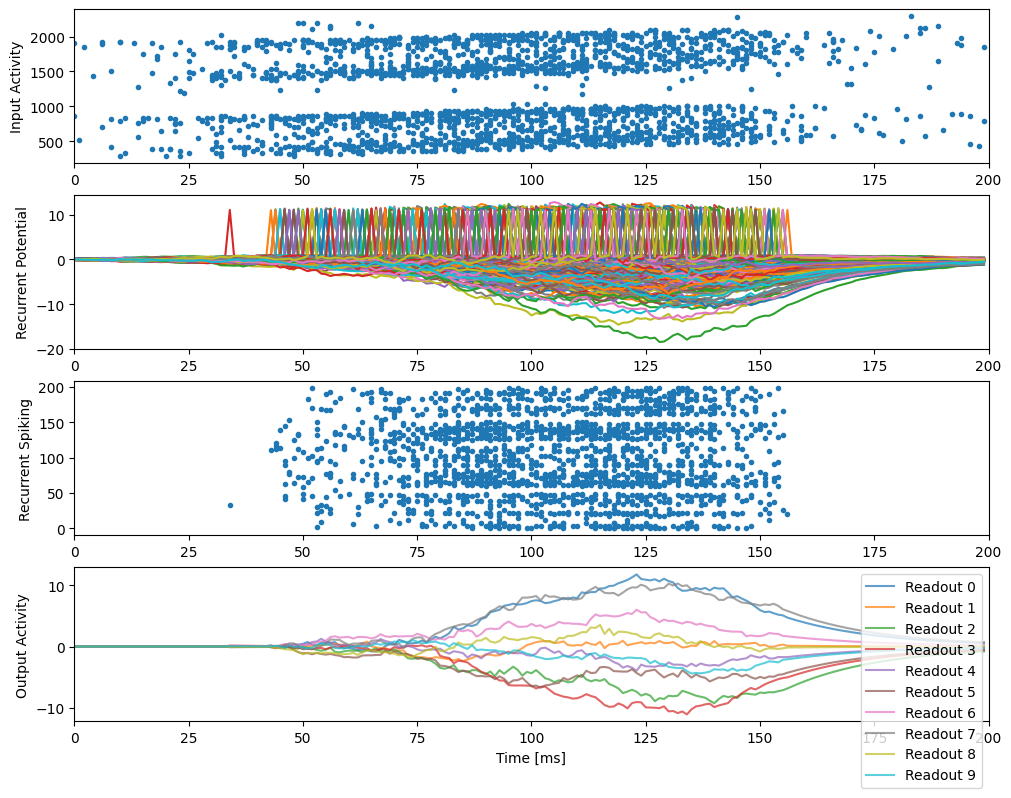

In [4]:
with bst.environ.context(dt=1. * u.ms):
    net = LIF_Delta_Net(
        n_in=int(np.prod(in_shape)),
        n_rec=200,
        n_out=out_shape,
        tau_mem=20. * u.ms,
        tau_o=20. * u.ms,
        V_th=1. * u.mV,
        rec_scale=2.,
        ff_scale=6.,
    )
    net.verify(next(iter(data))[0], num_show=1)

### 2.3 训练器

接下来，我们将实现一个训练器，用于训练各种脉冲神经网络。训练器的核心是``batch_train``函数，用于训练网络的一个批次数据。我们将实现两种训练器：一种是基于在线学习的训练器，另一种是基于BPTT的训练器。


In [5]:
from tqdm import tqdm
from typing import Iterable, Union
import jax

LOSS = float
ACCURACY = float


class Trainer(object):
    def __init__(
        self,
        target: bst.nn.Module,
        opt: bst.optim.Optimizer,
        dataset: Iterable,
        x_fun: Callable,
        n_sim: int = 0,
        batch_size: int = 128,
        acc_th: float = 0.90,
    ):
        super().__init__()

        # dataset
        self.dataset = dataset
        self.x_fun = x_fun

        # target network
        self.target = target

        # optimizer
        self.opt = opt
        weights = self.target.states().subset(bst.ParamState)
        opt.register_trainable_weights(weights)

        # training parameters
        self.n_sim = n_sim
        self.batch_size = batch_size
        self.acc_th = acc_th

    def _acc(self, out, target):
        return jax.numpy.mean(jax.numpy.equal(target, jax.numpy.argmax(jax.numpy.mean(out, axis=0), axis=1)))

    def batch_train(self, xs, ys) -> Union[LOSS, ACCURACY]:
        raise NotImplementedError

    def f_train(self):
        losses, accs = [], []
        n_batch = len(self.dataset)
        i_epoch = 0
        acc_ = 0.
        while acc_ < self.acc_th:
            i_epoch += 1
            bar = tqdm(enumerate(self.dataset))
            for i, (x_local, y_local) in bar:
                # training
                x_local = self.x_fun(x_local)  # [n_steps, n_samples, n_in]
                y_local = y_local  # [n_samples]
                loss, acc = self.batch_train(x_local, y_local)
                bar.set_description(f'loss = {loss:.5f}, acc={acc:.5f}', refresh=True)
                losses.append(loss)
                accs.append(acc)
            acc_ = np.mean(accs[-n_batch:])
            print(f'Epoch {i_epoch}, acc={acc_:.5f}, loss={np.mean(losses[-n_batch:]):.5f}')
        return np.asarray(losses), np.asarray(accs)


以下是基于在线学习的训练器的实现：

In [6]:
class OnlineTrainer(Trainer):
    def __init__(self, *args, decay_or_rank=0.99, **kwargs):
        super().__init__(*args, **kwargs)
        self.decay_or_rank = decay_or_rank

    @bst.compile.jit(static_argnums=(0,))
    def batch_train(self, inputs, targets):
        # initialize the states
        bst.nn.init_all_states(self.target, inputs.shape[1])

        # weights
        weights = self.target.states().subset(bst.ParamState)

        # initialize the online learning model
        # model = brainscale.DiagParamDimAlgorithm(self.target, mode=bst.mixin.Batching())
        model = brainscale.DiagIODimAlgorithm(self.target, self.decay_or_rank)
        model.compile_graph(inputs[0])

        def _etrace_grad(i, inp):
            # call the model
            out = model(inp, running_index=i)
            # calculate the loss
            loss = bts.metric.softmax_cross_entropy_with_integer_labels(out, targets).mean()
            return loss, out

        def _etrace_step(prev_grads, x):
            # no need to return weights and states, since they are generated then no longer needed
            i, inp = x
            f_grad = bst.augment.grad(_etrace_grad, weights, has_aux=True, return_value=True)
            cur_grads, local_loss, out = f_grad(i, inp)
            next_grads = jax.tree.map(lambda a, b: a + b, prev_grads, cur_grads)
            return next_grads, (out, local_loss)

        def _etrace_train(indices_, inputs_):
            # forward propagation
            grads = jax.tree.map(u.math.zeros_like, weights.to_dict_values())
            grads, (outs, losses) = bst.compile.scan(_etrace_step, grads, (indices_, inputs_))
            # gradient updates
            grads = bst.functional.clip_grad_norm(grads, 1.)
            self.opt.update(grads)
            # accuracy
            return losses.mean(), outs

        # running indices
        indices = np.arange(inputs.shape[0])
        if self.n_sim > 0:
            bst.compile.for_loop(lambda i, inp: model(inp, running_index=i), indices[:self.n_sim], inputs[:self.n_sim])
        loss, outs = _etrace_train(indices[self.n_sim:], inputs[self.n_sim:])

        # returns
        return loss, self._acc(outs, targets)


以下是基于BPTT的训练器的实现：

In [7]:
class BPTTTrainer(Trainer):
    @bst.compile.jit(static_argnums=(0,))
    def batch_train(self, inputs, targets):
        # initialize the states
        bst.nn.init_all_states(self.target, inputs.shape[1])

        # the model for a single step
        def _run_step_train(inp):
            out = self.target(inp)
            loss = bts.metric.softmax_cross_entropy_with_integer_labels(out, targets).mean()
            return out, loss

        def _bptt_grad_step():
            if self.n_sim > 0:
                _ = bst.compile.for_loop(self.target, inputs[:self.n_sim])
            outs, losses = bst.compile.for_loop(_run_step_train, inputs[self.n_sim:])
            return losses.mean(), outs

        # gradients
        weights = self.target.states().subset(bst.ParamState)
        grads, loss, outs = bst.augment.grad(_bptt_grad_step, weights, has_aux=True, return_value=True)()

        # optimization
        grads = bst.functional.clip_grad_norm(grads, 1.)
        self.opt.update(grads)

        return loss, self._acc(outs, targets)

### 2.4 在线学习 vs. BPTT离线学习

接下来，我们将比较在线学习和BPTT离线学习的性能。在线学习使用了``brainscale``中提供的``DiagIODimAlgorithm``算法，该算法是一种$O(N)$复杂度的在线学习算法，专门适用于脉冲神经网络的在线学习。BPTT使用了反向传播算法，该算法是一种离线学习算法，基于经典的代理梯度函数（surrogate gradient functions），BPTT可以有效地训练深度脉冲神经网络。


In [8]:
# 使用在线学习进行训练

with bst.environ.context(dt=1. * u.ms):
    onliner = OnlineTrainer(
        target=net,
        opt=bst.optim.Adam(lr=1e-3),
        dataset=data,
        x_fun=lambda x: np.transpose(x.reshape(*x.shape[:2], -1), (1, 0, 2)),
        acc_th=0.90,
    )

    losses, accs = onliner.f_train()

loss = 0.83508, acc=0.89453: : 234it [05:23,  1.38s/it]


Epoch 1, acc=0.85607, loss=1.05561


loss = 0.65360, acc=0.95312: : 234it [04:16,  1.10s/it]

Epoch 2, acc=0.92511, loss=0.72604


下面是在线学习的训练结果：

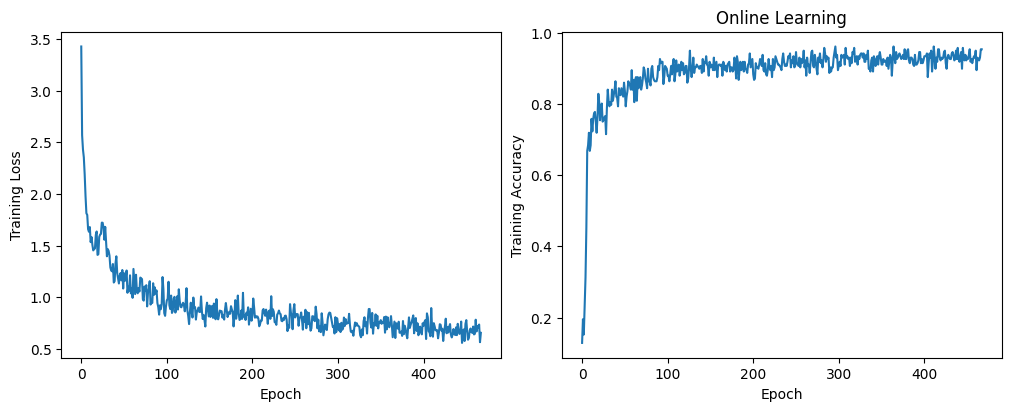

In [9]:
fig, gs = bts.visualize.get_figure(1, 2, 4., 5.)
fig.add_subplot(gs[0, 0])
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
fig.add_subplot(gs[0, 1])
plt.plot(accs)
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Online Learning')
plt.show()

我们可以可视化一个样本的网络活动：

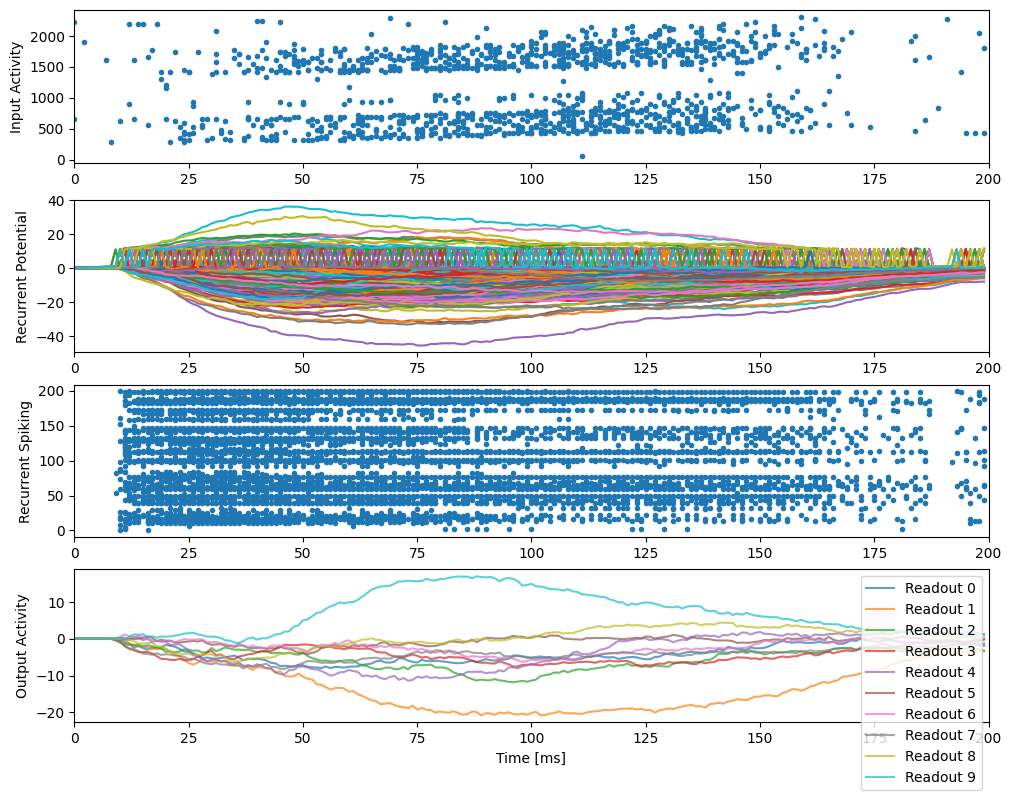

In [10]:
with bst.environ.context(dt=1. * u.ms):
    net.verify(next(iter(data))[0], num_show=1)

下面是BPTT离线学习的训练结果：

In [11]:
# 使用BPTT离线学习进行训练

with bst.environ.context(dt=1. * u.ms):
    net = LIF_Delta_Net(
        n_in=int(np.prod(in_shape)),
        n_rec=200,
        n_out=out_shape,
        tau_mem=20. * u.ms,
        tau_o=20. * u.ms,
        V_th=1. * u.mV,
        rec_scale=2.,
        ff_scale=6.,
    )

    offliner = BPTTTrainer(
        target=net,
        opt=bst.optim.Adam(lr=1e-3),
        dataset=data,
        x_fun=lambda x: np.transpose(x.reshape(*x.shape[:2], -1), (1, 0, 2)),
        acc_th=0.90,
    )

    losses, accs = offliner.f_train()

loss = 0.40394, acc=0.96875: : 234it [05:25,  1.39s/it]

Epoch 1, acc=0.91722, loss=0.66510


下面是BPTT离线学习的训练结果：

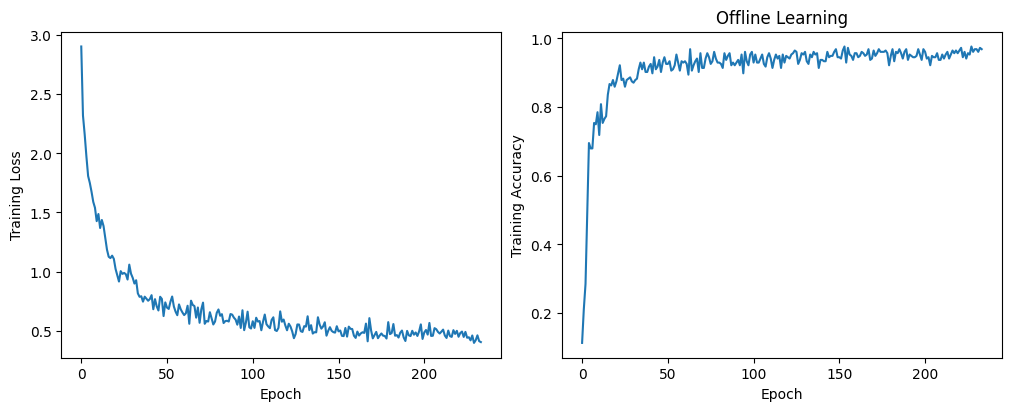

In [12]:
fig, gs = bts.visualize.get_figure(1, 2, 4., 5.)
fig.add_subplot(gs[0, 0])
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
fig.add_subplot(gs[0, 1])
plt.plot(accs)
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Offline Learning')
plt.show()

我们可以可视化一个样本的网络活动：

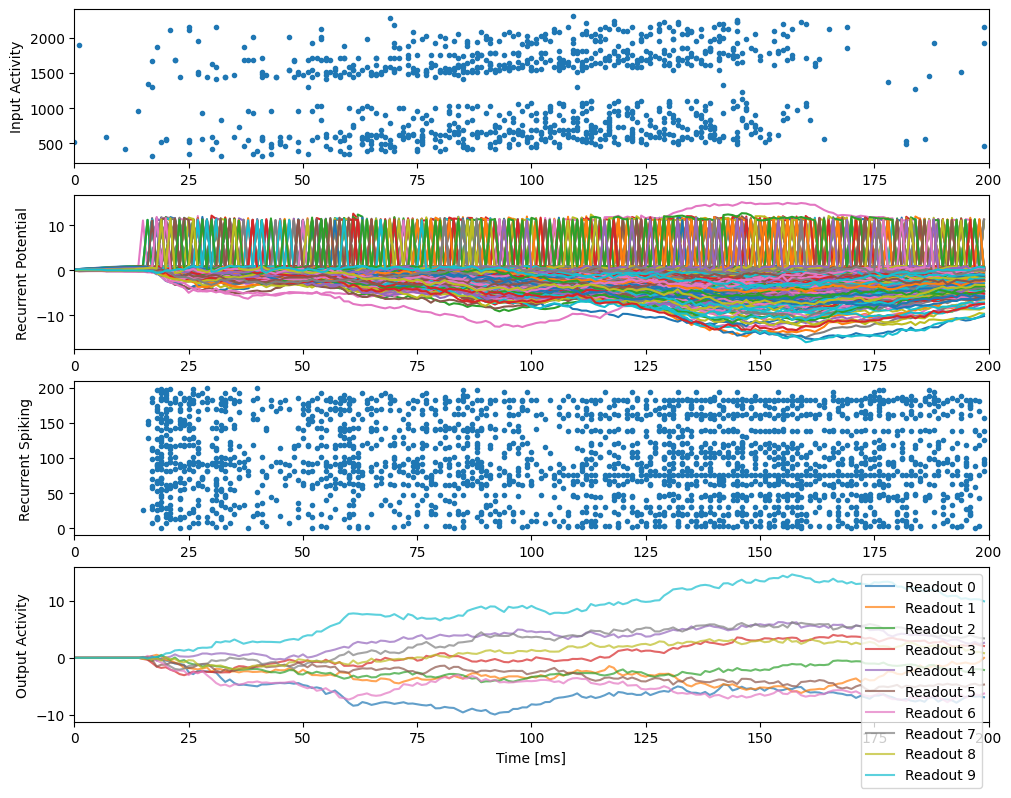

In [13]:
with bst.environ.context(dt=1. * u.ms):
    net.verify(next(iter(data))[0], num_show=1)

## 3. 使用GIF SNN进行DMS任务的在线学习

同时，脉冲神经网络还广泛地应用于各种脑仿真（brain simulation）任务，以研究工作记忆、学习和决策等的神经机制。

在这里，我们将使用上面介绍的脉冲神经网络模型，来解决一个较难的延迟样本匹配任务（Delayed Matching-to-Sample, DMS）。延迟样本匹配任务是一种经典的工作记忆任务，用于研究动物的工作记忆能力。在这个任务中，动物需要记住一个延迟时间内的样本，然后在延迟时间结束后，从多个选项中选择与样本相匹配的选项。这个任务可以用来研究动物的工作记忆能力，以及相关的神经机制。

我们使用的神经网络模型是一个三层的脉冲神经网络模型，包含一个输入层、一个隐藏层和一个输出层。隐藏层使用了广义积分发放（Generalized Integrate-and-Fire, GIF）神经元模型，包含了适应性电流机制。我们将使用这个脉冲神经网络模型，通过在线学习的方式，来解决延迟样本匹配任务。

### 3.1 广义积分发放神经网络

接下来，让我们实现一个广义积分发放（Generalized Integrate-and-Fire, GIF）神经元模型，并使用指数突触模型来构建一个简单的脉冲神经网络模型。

广义积分发放（Generalized Integrate-and-Fire, GIF）对经典积分发放模型的扩展,它可以更准确地描述真实神经元的动力学特性。与简单的积分发放模型相比,GIF模型考虑了动态阈值机制、适应性电流、后超极化效应、非线性膜响应等因素,从而更好地模拟神经元的动态行为。GIF模型的核心方程如下：

$$
\begin{aligned}
      &\frac{d I_j}{d t} = - k_j I_j \\
      &\tau \frac{d V}{d t} = - (V - V_\mathrm{rest}) + R\sum_{j}I_j + RI  \\
      &\frac{d V_{th}}{d t} = a(V - V_\mathrm{rest}) - b(V_{th} - V_{th\infty})
\end{aligned}
$$

当$V>V_{th}$时，广义LIF神经元会触发：

$$
\begin{aligned}
&I_j \leftarrow R_j I_j + A_j \\
&V \leftarrow V_\mathrm{reset} \\
&V_{th} \leftarrow max(V_{th,\mathrm{reset}}, V_\mathrm{th})
\end{aligned}
$$


其中，$V$ 是膜电位，$V_{rest}$ 是静息电位，$R$ 是膜电阻，$I$ 是输入电流，$V_{th}$ 是阈值电位，$V_{th\infty}$ 是静息阈值电位，$a$ 和 $b$ 是阈值动力学参数，$I_j$ 是适应性电流，表示任意数量的内部电流，$R_j$ 是适应性电流的衰减系数，$A_j$ 是适应性电流的增量，$V_\mathrm{reset}$ 是重置电位，$V_{th, \mathrm{reset}}$ 是阈值重置电位。


GIF模型通过引入多个参数和机制，能够模拟不同类型的神经元行为，例如：
- **适应性**：可以通过引入适应性电流，模拟神经元在重复刺激下的放电模式。
- **后发放抑制**：通过设置抑制机制来模拟发放后的短暂恢复期。
- **多种放电模式**：通过调整参数，模型可以重现各种生物神经元的放电特性，如快速发放、适应性发放和脉冲发放。

在这里，我们使用一个简化的GIF神经元模型，该神经元只包含了适应性电流机制，不包含后发放抑制和多种放电模式。其动力学方程如下：

$$
\begin{aligned}
&\tau_{\mathbf{a}}\frac{\mathrm{d}\mathbf{a}}{\mathrm{d}t}=-\mathbf{a},\\&\tau\frac{d\mathbf{v}}{dt}=-\mathbf{v}+V_{\mathrm{rest}}+\mathbf{a}+\mathbf{I},\end{aligned}
$$

其中$\mathbf{a}$表示内部自适应电流，$\tau_\mathbf{a}$是自适应电流的时间常数。当第$i$个神经元的$v_i$满足$V_\mathrm{th}$时，模型触发：

$$
\mathbf{a}_{i}\leftarrow\mathbf{a}_{i}+A,\\
\mathbf{v}_{i}\leftarrow V_{\mathrm{reset}},
$$


我们将上述方程转化为离散形式，得到：

$$
\begin{aligned}&\bar{\mathbf{v}}^{t-1}=\mathbf{v}^{t-1}+\mathbf{z}^{t-1}(V_{\mathrm{reset}}-\mathbf{v}^{t-1}),\\&\mathbf{a}^{t}=e^{-\Delta t/\tau_{\mathbf{a}}}\mathbf{a}^{t-1}+\mathbf{z}^{t-1}A,\\&\mathbf{v}^{t}=e^{-\Delta t/\tau}\bar{\mathbf{v}}^{t-1}+(1-e^{-\Delta t/\tau})(V_{\mathrm{rest}}+\mathbf{I}^{t}+\mathbf{a}^{t}).\end{aligned}
$$

以下是这个GIF神经元模型的实现：

In [14]:
from typing import Callable


class GIF(bst.nn.Neuron):
    def __init__(
        self, size,
        V_rest=0. * u.mV,
        V_th_inf=1. * u.mV,
        R=1. * u.ohm,
        tau=20. * u.ms,
        tau_I2=50. * u.ms,
        A2=0. * u.mA,
        V_initializer: Callable = bst.init.ZeroInit(unit=u.mV),
        I2_initializer: Callable = bst.init.ZeroInit(unit=u.mA),
        spike_fun: Callable = bst.surrogate.ReluGrad(),
        spk_reset: str = 'soft',
        keep_size: bool = False,
        name: str = None,
    ):
        super().__init__(size, keep_size=keep_size, name=name, spk_fun=spike_fun, spk_reset=spk_reset)

        # parameters
        self.V_rest = bst.init.param(V_rest, self.varshape, allow_none=False)
        self.V_th_inf = bst.init.param(V_th_inf, self.varshape, allow_none=False)
        self.R = bst.init.param(R, self.varshape, allow_none=False)
        self.tau = bst.init.param(tau, self.varshape, allow_none=False)
        self.tau_I2 = bst.init.param(tau_I2, self.varshape, allow_none=False)
        self.A2 = bst.init.param(A2, self.varshape, allow_none=False)

        # initializers
        self._V_initializer = V_initializer
        self._I2_initializer = I2_initializer

    def init_state(self, batch_size=None):
        # 将模型用于在线学习，需要初始化状态变量
        self.V = brainscale.ETraceState(bst.init.param(self._V_initializer, self.varshape, batch_size))
        self.I2 = brainscale.ETraceState(bst.init.param(self._I2_initializer, self.varshape, batch_size))

    def update(self, x=0.):
        # 如果前一时刻发放了脉冲，则将膜电位和适应性电流进行重置
        last_spk = self.get_spike()
        last_spk = jax.lax.stop_gradient(last_spk)
        last_V = self.V.value - self.V_th_inf * last_spk
        last_I2 = self.I2.value - self.A2 * last_spk
        # 更新状态
        I2 = bst.nn.exp_euler_step(lambda i2: - i2 / self.tau_I2, last_I2)
        V = bst.nn.exp_euler_step(lambda v, Iext: (- v + self.V_rest + self.R * Iext) / self.tau,
                                  last_V, x + I2)
        self.I2.value = I2
        self.V.value = V
        # 输出
        inp = self.V.value - self.V_th_inf
        inp = jax.nn.standardize(u.get_magnitude(inp))
        return inp

    def get_spike(self, V=None):
        V = self.V.value if V is None else V
        spk = self.spk_fun((V - self.V_th_inf) / self.V_th_inf)
        return spk

在上面的代码中，我们使用指数欧拉方法来更新神经元的状态，其中包括膜电位和适应性电流。在每个时间步，我们计算膜电位和适应性电流的变化，并根据阈值电位是否超过阈值来判断是否发放脉冲。如果发放脉冲，则将膜电位和适应性电流进行重置。

接下来，我们将使用这个GIF神经元模型+指数突触模型来构建一个三层的脉冲神经网络模型，第一层是输入层，第二层是隐藏层，第三层是输出层。

In [15]:
class GifNet(bst.nn.Module):
    def __init__(
        self,
        n_in: int,
        n_rec: int,
        n_out: int,
        ff_scale: float = 1.,
        rec_scale: float = 1.,
        tau_neu: float = 5. * u.ms,
        tau_syn: float = 5. * u.ms,
        tau_I2: float = 5. * u.ms,
        A2=-1. * u.mA,
        tau_o: float = 5. * u.ms,
    ):
        super().__init__()

        # 初始化权重
        ff_init = bst.init.KaimingNormal(ff_scale, unit=u.mA)
        rec_init = bst.init.KaimingNormal(rec_scale, unit=u.mA)
        w = u.math.concatenate([ff_init((n_in, n_rec)), rec_init((n_rec, n_rec))], axis=0)

        # 参数
        self.n_in = n_in
        self.n_rec = n_rec
        self.n_out = n_out

        # 模型层
        self.ir2r = brainscale.nn.Linear(n_in + n_rec, n_rec, w_init=w, b_init=bst.init.ZeroInit(unit=u.mA))
        self.exp = brainscale.nn.Expon(n_rec, tau=tau_syn, g_initializer=bst.init.ZeroInit(unit=u.mA))
        self.r = GIF(
            n_rec,
            V_rest=0. * u.mV,
            V_th_inf=1. * u.mV,
            A2=A2,
            tau=tau_neu,
            tau_I2=bst.random.uniform(100. * u.ms, tau_I2 * 1.5, n_rec),
        )
        self.out = brainscale.nn.LeakyRateReadout(n_rec, n_out, tau=tau_o, w_init=bst.init.KaimingNormal())

    def update(self, spikes):
        cond = self.ir2r(u.math.concatenate([spikes, self.r.get_spike()], axis=-1))
        out = self.r(self.exp(cond))
        return self.out(out)

    def verify(self, input_spikes, num_show=5, sps_inc=10.):
        def _step(x):
            out = self.update(x)
            return out, self.r.get_spike(), self.r.V.value

        # 输入脉冲
        xs = np.transpose(input_spikes, (1, 0, 2))  # [n_steps, n_samples, n_in]

        # 运行仿真模型
        bst.nn.init_all_states(self, xs.shape[1])
        outs, sps, vs = bst.compile.for_loop(_step, xs)
        outs = u.math.as_numpy(outs)
        sps = u.math.as_numpy(sps)
        vs = u.math.as_numpy(vs.to_decimal(u.mV))
        vs = np.where(sps, vs + sps_inc, vs)
        max_t = xs.shape[0]

        for i in range(num_show):
            fig, gs = bts.visualize.get_figure(4, 1, 2., 10.)

            # 输入活动可视化
            ax_inp = fig.add_subplot(gs[0, 0])
            t_indices, n_indices = np.where(xs[:, i] > 0)
            ax_inp.plot(t_indices, n_indices, '.')
            ax_inp.set_xlim(0., max_t)
            ax_inp.set_ylabel('Input Activity')

            # 神经元活动可视化
            ax = fig.add_subplot(gs[1, 0])
            plt.plot(vs[:, i])
            ax.set_xlim(0., max_t)
            ax.set_ylabel('Recurrent Potential')

            # 脉冲活动可视化
            ax_rec = fig.add_subplot(gs[2, 0])
            t_indices, n_indices = np.where(sps[:, i] > 0)
            ax_rec.plot(t_indices, n_indices, '.')
            ax_rec.set_xlim(0., max_t)
            ax_rec.set_ylabel('Recurrent Spiking')

            # 输出活动可视化
            ax_out = fig.add_subplot(gs[3, 0])
            for j in range(outs.shape[-1]):
                ax_out.plot(outs[:, i, j], label=f'Readout {j}', alpha=0.7)
            ax_out.set_ylabel('Output Activity')
            ax_out.set_xlabel('Time [ms]')
            ax_out.set_xlim(0., max_t)
            plt.legend()

        plt.show()
        plt.close()

### 3.2 延迟样本匹配任务

我们准备使用上面定义的脉冲神经网络模型来解决一个延迟样本匹配任务。

在这里，我们首先构建这个延迟样本匹配任务的数据集。

In [16]:
import numba


@numba.njit
def _dms(num_steps, num_inputs, n_motion_choice, motion_tuning,
         sample_time, test_time, fr, bg_fr, rotate_dir):
    # data
    X = np.zeros((num_steps, num_inputs))

    # sample
    match = np.random.randint(2)
    sample_dir = np.random.randint(n_motion_choice)

    # Generate the sample and test stimuli based on the rule
    if match == 1:  # match trial
        test_dir = (sample_dir + rotate_dir) % n_motion_choice
    else:
        test_dir = np.random.randint(n_motion_choice)
        while test_dir == ((sample_dir + rotate_dir) % n_motion_choice):
            test_dir = np.random.randint(n_motion_choice)

    # SAMPLE stimulus
    X[sample_time] += motion_tuning[sample_dir] * fr
    # TEST stimulus
    X[test_time] += motion_tuning[test_dir] * fr
    X += bg_fr

    # to spiking
    X = np.random.random(X.shape) < X
    X = X.astype(np.float32)

    # can use a greater weight for test period if needed
    return X, match


class DMSDataset:
    """
    Delayed match-to-sample task.
    """
    times = ('dead', 'fixation', 'sample', 'delay', 'test')
    output_features = ('non-match', 'match')

    _rotate_choice = {
        '0': 0,
        '45': 1,
        '90': 2,
        '135': 3,
        '180': 4,
        '225': 5,
        '270': 6,
        '315': 7,
        '360': 8,
    }

    def __init__(
        self,
        t_fixation=500. * u.ms,
        t_sample=500. * u.ms,
        t_delay=1000. * u.ms,
        t_test=500. * u.ms,
        limits=(0., np.pi * 2),
        rotation_match='0',
        kappa=3.,
        bg_fr=1. * u.Hz,
        n_input=100,
        firing_rate=100. * u.Hz,
        batch_size: int = 128,
        num_batch: int = 1000,
    ):
        super().__init__()

        # parameters
        self.num_batch = num_batch
        self.batch_size = batch_size
        self.num_inputs = n_input
        self.num_outputs = 2
        self.firing_rate = firing_rate
        dt = bst.environ.get_dt()

        # time
        self.t_fixation = int(t_fixation / dt)
        self.t_sample = int(t_sample / dt)
        self.t_delay = int(t_delay / dt)
        self.t_test = int(t_test / dt)
        self.num_steps = self.t_fixation + self.t_sample + self.t_delay + self.t_test
        test_onset = self.t_fixation + self.t_sample + self.t_delay
        self._test_onset = test_onset
        self.test_time = slice(test_onset, test_onset + self.t_test)
        self.fix_time = slice(0, test_onset)
        self.sample_time = slice(self.t_fixation, self.t_fixation + self.t_sample)

        # input shape
        self.rotation_match = rotation_match
        self._rotate = self._rotate_choice[rotation_match]
        self.bg_fr = bg_fr  # background firing rate
        self.v_min = limits[0]
        self.v_max = limits[1]
        self.v_range = limits[1] - limits[0]

        # Tuning function data
        self.n_motion_choice = 8
        self.kappa = kappa  # concentration scaling factor for von Mises

        # Generate list of preferred directions
        # dividing neurons by 2 since two equal
        # groups representing two modalities
        pref_dirs = np.arange(self.v_min, self.v_max, self.v_range / self.num_inputs)

        # Generate list of possible stimulus directions
        stim_dirs = np.arange(self.v_min, self.v_max, self.v_range / self.n_motion_choice)

        d = np.cos(np.expand_dims(stim_dirs, 1) - pref_dirs)
        self.motion_tuning = np.exp(self.kappa * d) / np.exp(self.kappa)

    @property
    def n_sim(self):
        return self._test_onset

    def __len__(self):
        return self.num_batch

    def __iter__(self):
        # firing rate
        fr = np.asarray(self.firing_rate * bst.environ.get_dt())
        bg_fr = np.asarray(self.bg_fr * bst.environ.get_dt())

        # generate data
        for _ in range(self.num_batch):
            xs, ys = [], []
            for _ in range(self.batch_size):
                x, y = _dms(self.num_steps,
                            self.num_inputs,
                            self.n_motion_choice,
                            self.motion_tuning,
                            self.sample_time,
                            self.test_time,
                            fr,
                            bg_fr,
                            self._rotate)
                xs.append(x)
                ys.append(y)
            yield np.asarray(xs), np.asarray(ys)

在上面的代码中，我们定义了一个延迟样本匹配任务的数据集，其中包含了样本时间、测试时间、延迟时间等参数。我们使用von Mises函数来生成样本和测试的方向，然后将其转化为脉冲活动。我们还定义了一个`DMSDataset`类，用于生成延迟样本匹配任务的数据集。

我们可以对一个样本数据进行可视化，以便更好地理解延迟样本匹配任务。

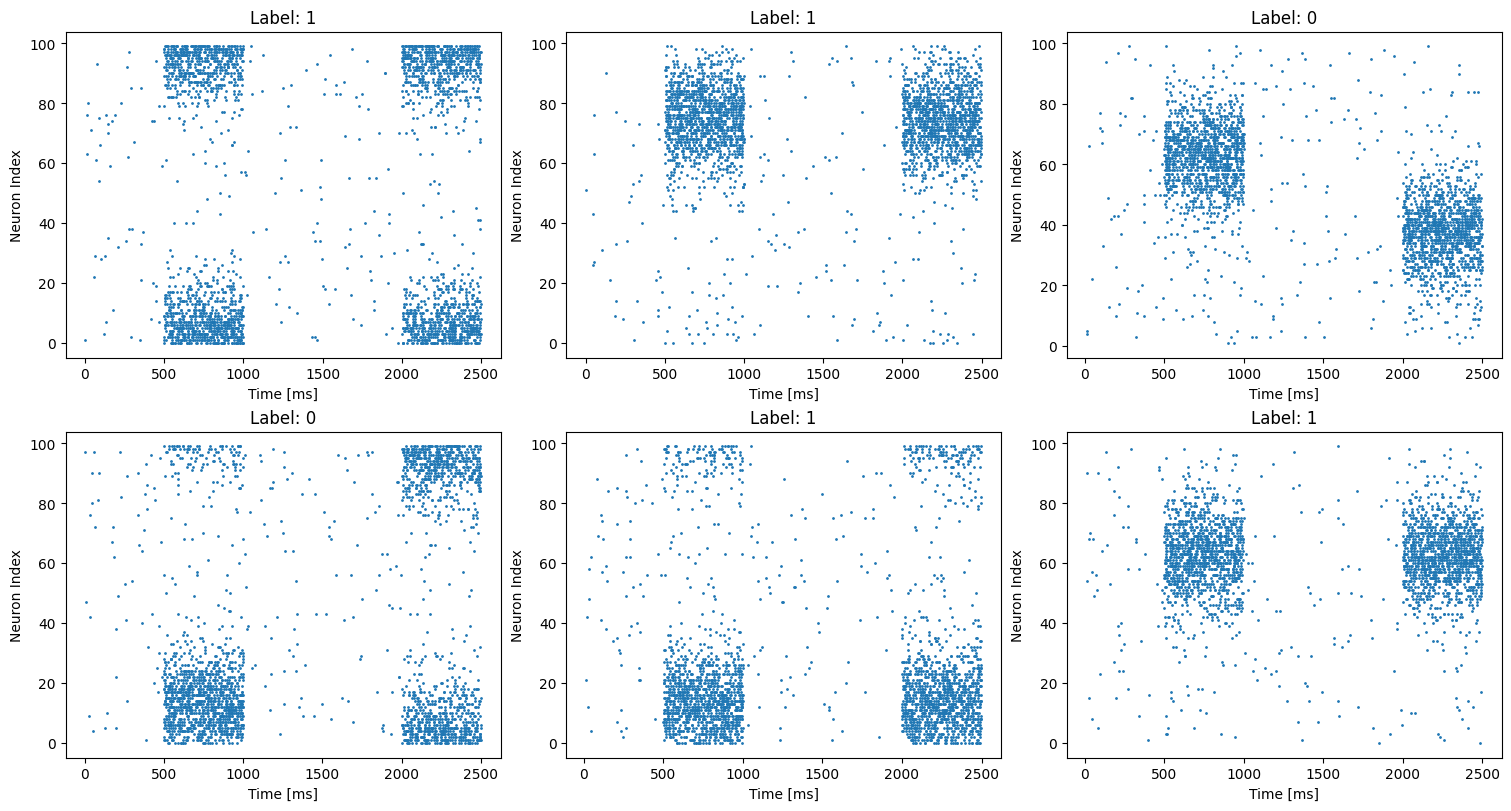

In [17]:
with bst.environ.context(dt=1. * u.ms):
    xs, ys = next(iter(DMSDataset()))

fig, gs = bts.visualize.get_figure(2, 3, 4., 5.)
for i in range(6):
    ax = fig.add_subplot(gs[i // 3, i % 3])
    t_indices, n_indices = np.where(xs[i] > 0)
    ax.scatter(t_indices, n_indices, s=1)
    ax.set_title(f'Label: {ys[i]}')
    ax.set_xlabel('Time [ms]')
    ax.set_ylabel('Neuron Index')

### 3.3 基于在线学习算法进行训练

接下来，我们将使用上面定义的脉冲神经网络模型，通过在线学习的方式，来解决延迟样本匹配任务。我们将使用在线学习算法，通过不断地更新神经网络的权重，来提高网络的性能。

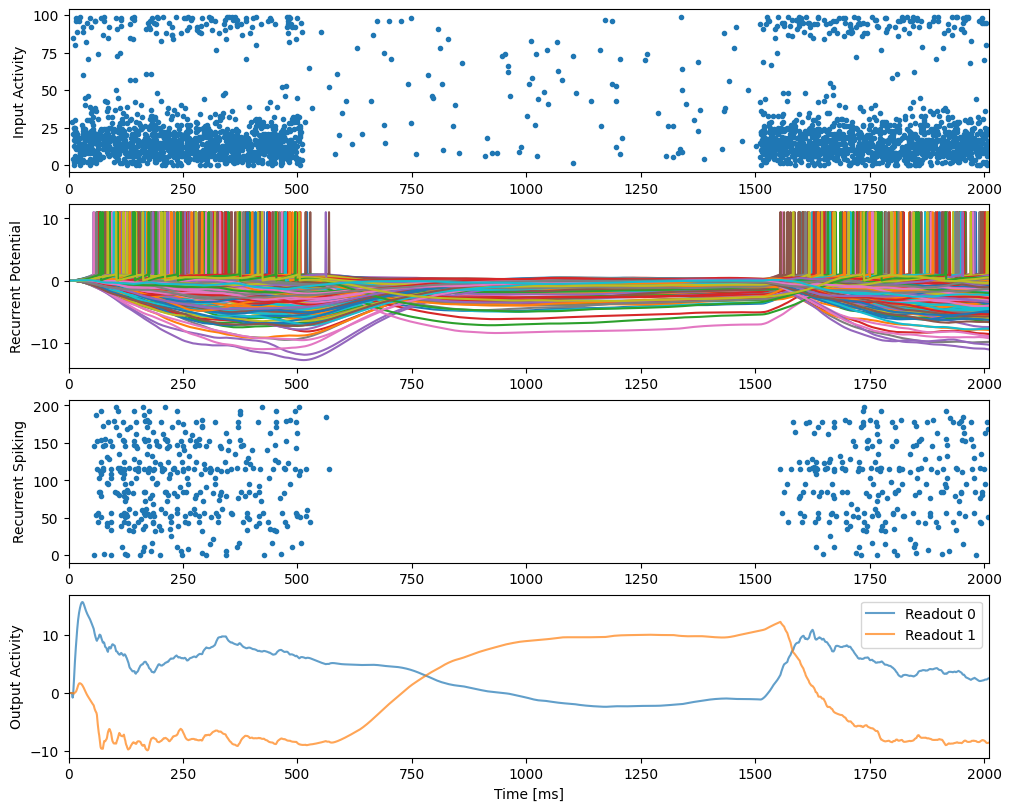

loss = 0.64602, acc=0.71875: : 100it [03:28,  2.09s/it]


Epoch 1, acc=0.67227, loss=1.19286


loss = 0.44066, acc=0.91406: : 100it [03:25,  2.06s/it]


Epoch 2, acc=0.81477, loss=0.55273


loss = 0.37656, acc=0.94531: : 100it [03:22,  2.03s/it]

Epoch 3, acc=0.90562, loss=0.42928


In [20]:
with bst.environ.context(dt=1. * u.ms):
    data = DMSDataset(
        bg_fr=1. * u.Hz,
        t_fixation=10. * u.ms,
        t_sample=500. * u.ms,
        t_delay=1000. * u.ms,
        t_test=500. * u.ms,
        n_input=100,
        firing_rate=100. * u.Hz,
        batch_size=128,
        num_batch=100,
    )
    net = GifNet(
        n_in=data.num_inputs,
        n_rec=200,
        n_out=data.num_outputs,
        tau_neu=100. * u.ms,
        tau_syn=100. * u.ms,
        tau_I2=1500. * u.ms,
        A2=1. * u.mA,
    )
    net.verify(next(iter(data))[0], num_show=1)

    onliner = OnlineTrainer(
        target=net,
        opt=bst.optim.Adam(lr=1e-3),
        dataset=data,
        n_sim=data.n_sim,
        x_fun=lambda x_local: np.transpose(x_local, (1, 0, 2))
    )

    losses, accs = onliner.f_train()

下面是在线学习的训练结果：

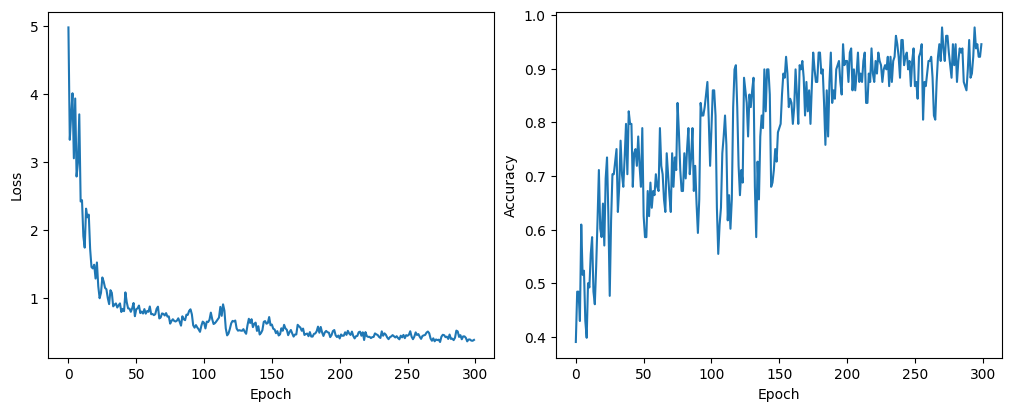

In [21]:
fig, gs = bts.visualize.get_figure(1, 2, 4., 5.)
fig.add_subplot(gs[0, 0])
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
fig.add_subplot(gs[0, 1])
plt.plot(accs)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

我们可以可视化一个样本的网络活动：

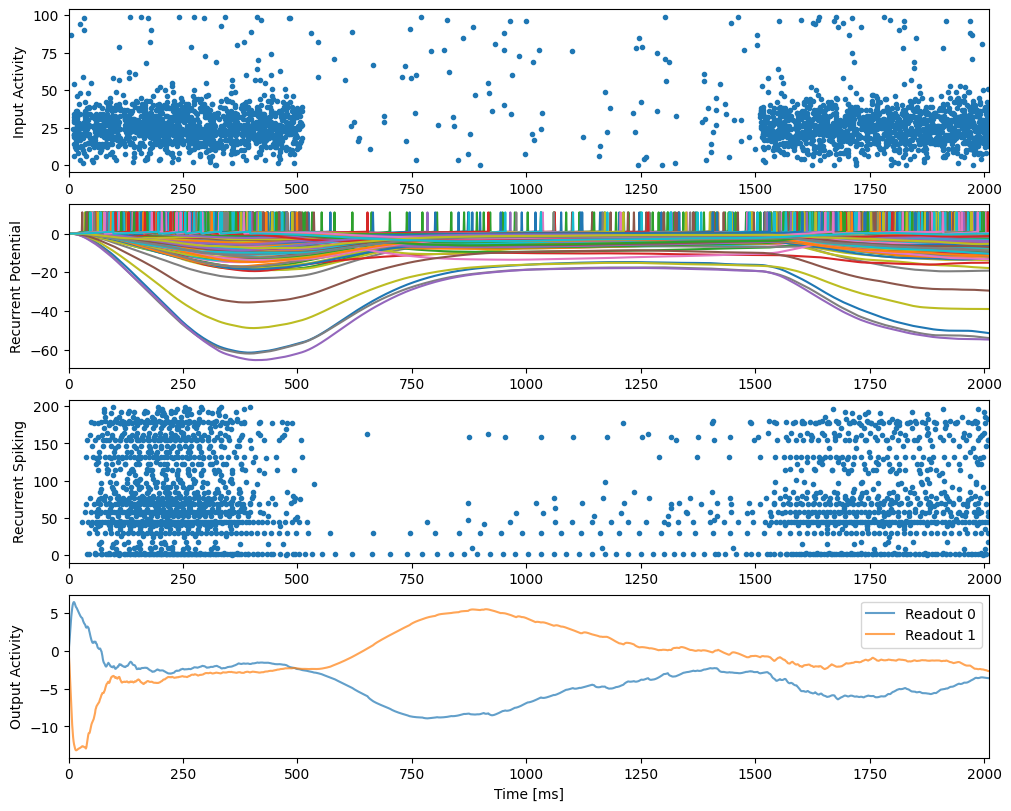

In [22]:
with bst.environ.context(dt=1. * u.ms):
    net.verify(next(iter(data))[0], num_show=1)

### 3.4 基于BPTT算法进行训练

我们也可以轻松地对比在线学习和BPTT离线学习的性能。接下来，我们将使用BPTT离线学习算法来训练这一网络。

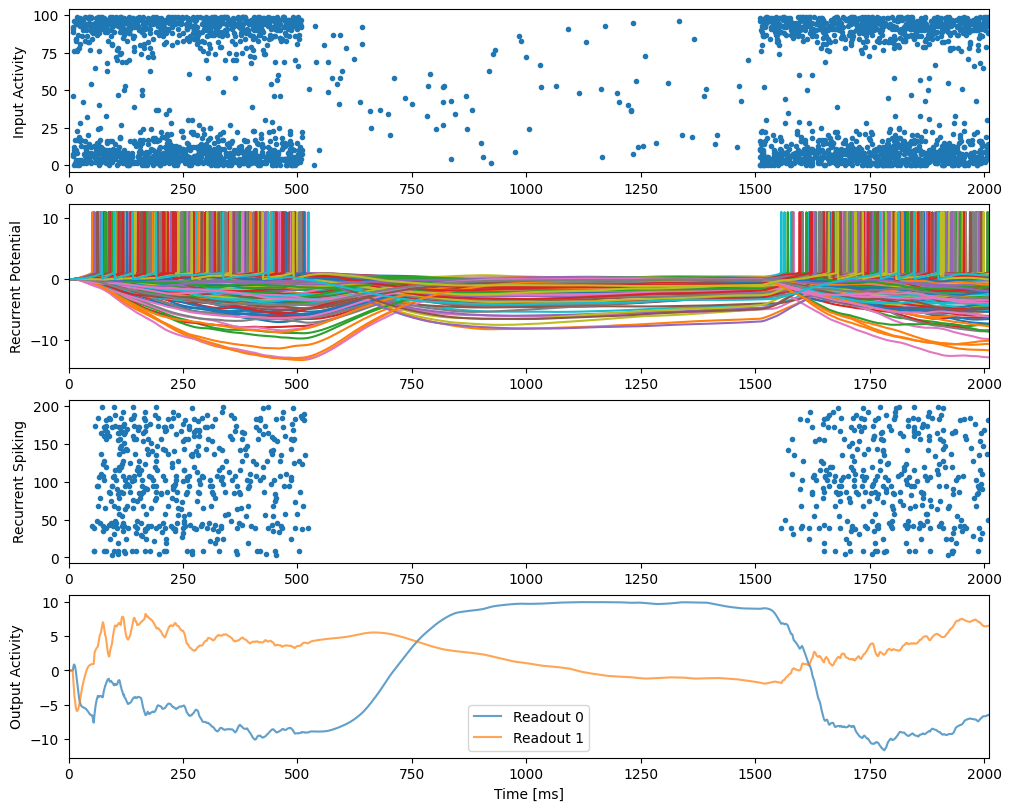

loss = 4.34492, acc=0.51562: : 100it [07:27,  4.47s/it]


Epoch 1, acc=0.54164, loss=4.51506


loss = 4.45029, acc=0.46875: : 100it [07:33,  4.53s/it]


Epoch 2, acc=0.52906, loss=4.47490


loss = 4.51000, acc=0.53125: : 100it [07:24,  4.45s/it]


Epoch 3, acc=0.54594, loss=4.31876


loss = 4.08650, acc=0.60156: : 100it [06:29,  3.90s/it]


Epoch 4, acc=0.53703, loss=4.43020


loss = 4.16506, acc=0.57031: : 100it [06:26,  3.86s/it]


Epoch 5, acc=0.54008, loss=4.37322


loss = 3.91350, acc=0.61719: : 100it [05:58,  3.59s/it]


Epoch 6, acc=0.54312, loss=4.35027


loss = 4.63991, acc=0.54688: : 100it [05:37,  3.38s/it]


Epoch 7, acc=0.53125, loss=4.48663


loss = 4.32466, acc=0.56250: : 68it [04:01,  3.55s/it]


KeyboardInterrupt: 

In [23]:
with bst.environ.context(dt=1. * u.ms):
    data = DMSDataset(
        bg_fr=1. * u.Hz,
        t_fixation=10. * u.ms,
        t_sample=500. * u.ms,
        t_delay=1000. * u.ms,
        t_test=500. * u.ms,
        n_input=100,
        firing_rate=100. * u.Hz,
        batch_size=128,
        num_batch=100,
    )
    net = GifNet(
        n_in=data.num_inputs,
        n_rec=200,
        n_out=data.num_outputs,
        tau_neu=100. * u.ms,
        tau_syn=100. * u.ms,
        tau_I2=1500. * u.ms,
        A2=1. * u.mA,
    )
    net.verify(next(iter(data))[0], num_show=1)

    offliner = BPTTTrainer(
        target=net,
        opt=bst.optim.Adam(lr=1e-3),
        dataset=data,
        n_sim=data.n_sim,
        x_fun=lambda x_local: np.transpose(x_local, (1, 0, 2))
    )

    losses, accs = offliner.f_train()

很遗憾，我们没有看到BPTT离线学习在这个任务上有效收敛。

我们可以可视化一个样本的网络活动：

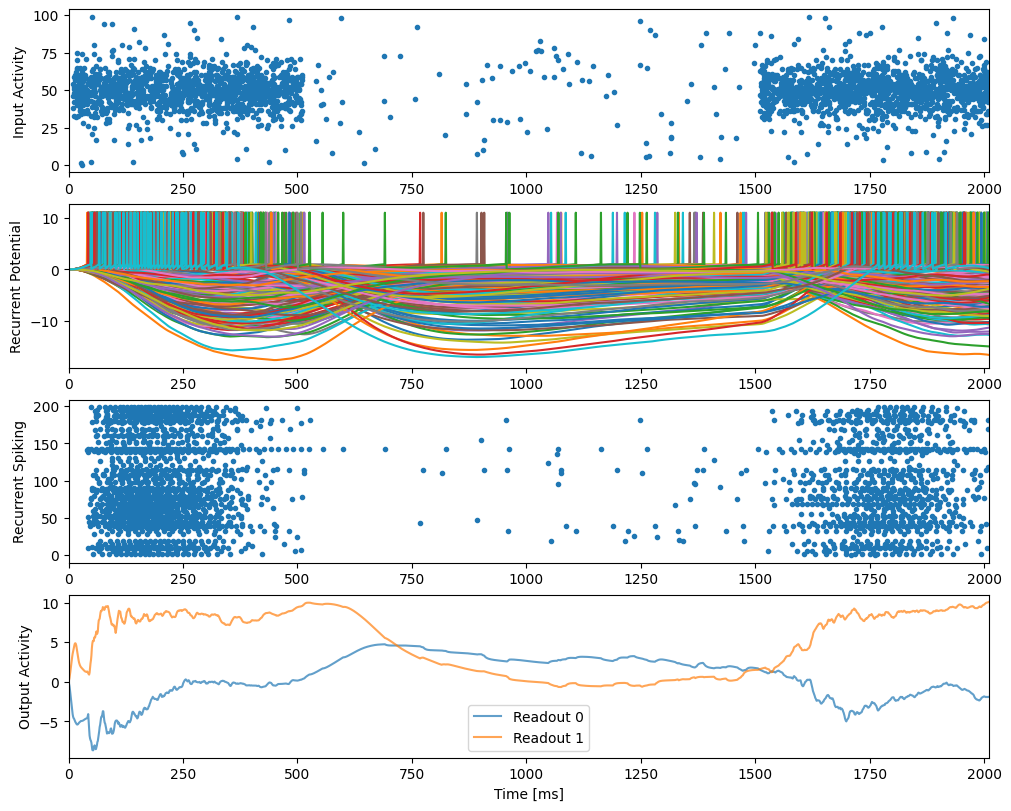

In [24]:
with bst.environ.context(dt=1. * u.ms):
    net.verify(next(iter(data))[0], num_show=1)

## 4. 总结

这篇文档深入探讨了如何将``brainscale``用于脉冲神经网络的在线学习机制，内容可分为两个主要层面：

1. 理论基础
    - 详细介绍了SNN的三个核心组成部分：神经元动力学、突触动力学和网络动力学
    - 重点阐述了漏积分发放(LIF)神经元模型和广义积分发放(GIF)神经元模型的数学原理

2. 实践应用
    - 以Neuromorphic-MNIST(N-MNIST)数据集为例，展示了如何使用``brainscale``训练类脑计算模型解决视觉分类任务
    - 通过延迟样本匹配(DMS)任务，展示了如何使用``brainscale``训练脑仿真模型解决经典的工作记忆任务
    - 对比了在线学习和基于BPTT的离线学习方法之间的区别和性能

希望这份文档通过理论分析和实验验证的结合，能为读者理解和应用``brainscale``解决SNN的在线学习提供了一个好的参考。